# Fantasia database contains both ECG with R-peaks annotations and respiratory signal, sampled with the same frequency of 250 Hz

## ECGs

In [1]:
import os
import numpy as np
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
from customLib.vis import *
from customLib.preprocess import *
from customLib.load_physionet_ecgs import load_physionet_ecgs
from customLib.dataset import split_dataset
from customLib.config import fantasia_path
from customLib.vis import plot_ecg

In [2]:
file = os.path.join(fantasia_path, "f2y02")

record = wfdb.rdrecord(file)
annotation = wfdb.rdann(file, extension="ecg") #ecg

sampling_rate = record.fs
n_channels = record.n_sig

print("Total channels: ", n_channels)
sig = record.p_signal
print("Signal shape: ", sig.shape)
print("Signals: ", record.sig_name)
print("Sampling rate: ", record.fs)

sig_1 = sig[:,0]
sig_2 = sig[:,1]

r_peaks_annotation = annotation.sample

r_peaks = np.zeros_like(sig_2)
r_peaks[r_peaks_annotation] = 1


Total channels:  3
Signal shape:  (2342528, 3)
Signals:  ['RESP', 'ECG', 'BP']
Sampling rate:  333


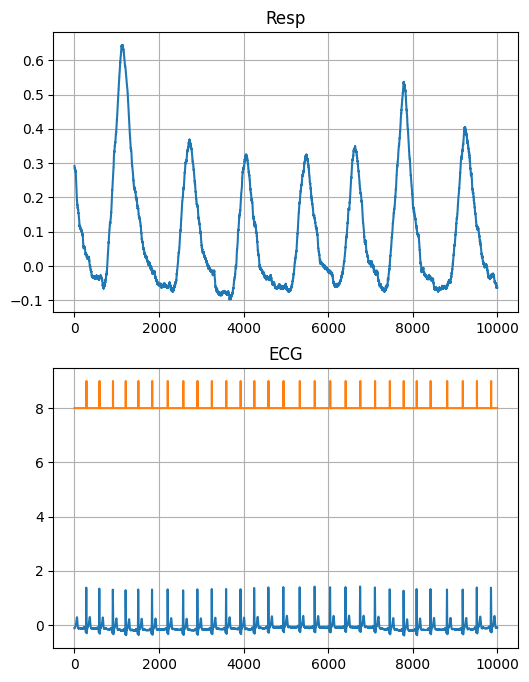

In [3]:
last_sample = 10000
fig, axs = plt.subplots(nrows=2, ncols=1)

ax = axs[0]
ax.plot(sig_1[:last_sample])
ax.set_title("Resp")
ax.grid()

ax = axs[1]
ax.plot(sig_2[:last_sample])
ax.plot(r_peaks[:last_sample] + 8)
ax.set_title("ECG")
ax.grid()

fig.set_size_inches(6,8)


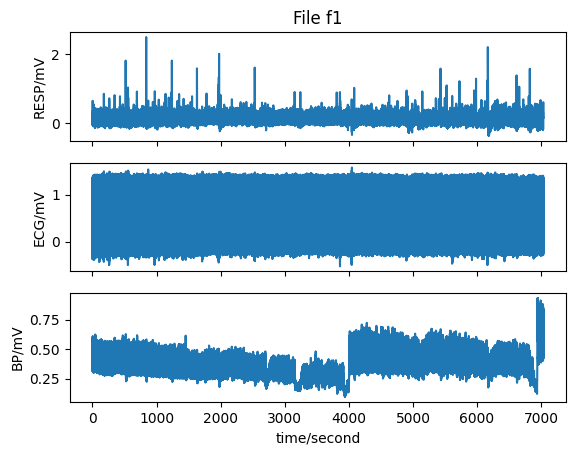

In [4]:
wfdb.plot_wfdb(record=record, title="File f1")

In [5]:
# denoised, smoothened, normalized ECGs
x, y = load_physionet_ecgs(path=fantasia_path,  annotation_file_extension="ecg", window_in_seconds=10, force_new=True, denoise=True, expand=False, normalize=True, smoothen=True)

ECGs sampling rate:  250


 80%|████████  | 32/40 [01:51<00:21,  2.74s/it]

Skipping file f2y02 due to a different sampling rate (target: 250, file: 333)


100%|██████████| 40/40 [02:26<00:00,  3.65s/it]


In [12]:
# downsample preprocessed ECGs
x = np.load(fantasia_path + "\\preprocessed\\x.npy")
y = np.load(fantasia_path + "\\preprocessed\\y.npy")

res_x = []
res_y = []

for i in range(x.shape[0]):
  res_x.append(resample_signal(x[i], 1000))

for i in range(y.shape[0]):
 res_y.append(downsample_r_peaks_probability(r_peaks_probability=y[i], original_fs=250, target_fs=100))

#res_y = expand_labels(res_y, left_shift=5, right_shift=6)
res_x = np.array(res_x)
res_y = np.array(res_y)

np.save(fantasia_path + "\\preprocessed\\downsampled\\x.npy", res_x)
np.save(fantasia_path + "\\preprocessed\\downsampled\\y.npy", res_y)

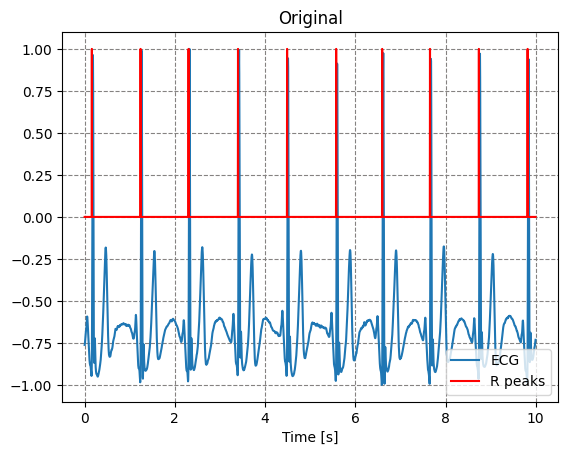

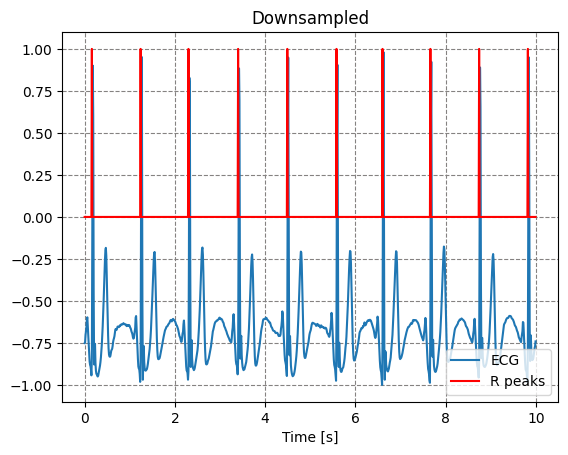

In [14]:
plot_ecg(x[-1], y[-1], fs=250, title="Original")
plot_ecg(res_x[-1], res_y[-1], fs=100, title="Downsampled")

In [15]:
# raw ecgs
x_raw, y_raw = load_physionet_ecgs(path=fantasia_path, annotation_file_extension="ecg", window_in_seconds=10, raw=True)

ECGs sampling rate:  250


 80%|████████  | 32/40 [00:07<00:02,  3.26it/s]

Skipping file f2y02 due to a different sampling rate (target: 250, file: 333)


100%|██████████| 40/40 [00:11<00:00,  3.52it/s]


In [22]:
# downsample raw ECGs

x = np.load(fantasia_path + "\\preprocessed\\raw\\x.npy")
y = np.load(fantasia_path + "\\preprocessed\\raw\\y.npy")

res_x = []
res_y = []

for i in range(x.shape[0]):
  res_x.append(resample_signal(x[i], 1000))

for i in range(y.shape[0]):
 res_y.append(downsample_r_peaks_probability(r_peaks_probability=y[i], original_fs=250, target_fs=100))

#res_y = expand_labels(res_y, left_shift=5, right_shift=6)
res_x = np.array(res_x)
res_y = np.array(res_y)

np.save(fantasia_path + "\\preprocessed\\raw\\downsampled\\x.npy", res_x)
np.save(fantasia_path + "\\preprocessed\\raw\\downsampled\\y.npy", res_y)

#path = fantasia_path + "\\dataset\\downsampled"
#x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(res_x, res_y, split_ratio=0.75, shuffle=True, is_validation_set=True, path=path)

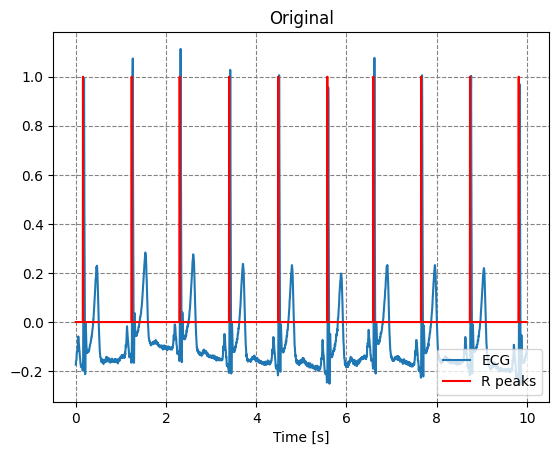

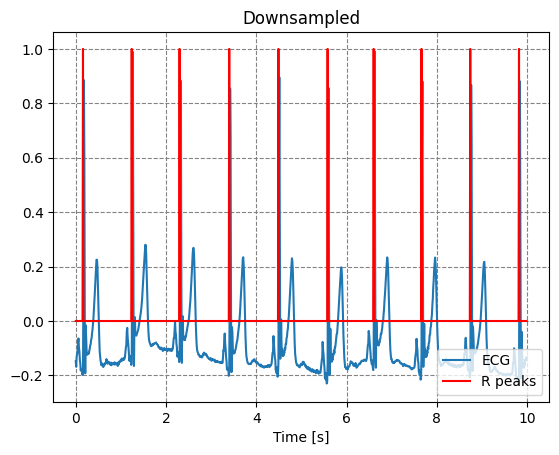

In [23]:
plot_ecg(x[-1], y[-1], fs=250, title="Original")
plot_ecg(res_x[-1], res_y[-1], fs=100, title="Downsampled")

### Test 3 models - LSTM, ST_RES_NET, Transformer_RR for R-peak detection on preprocessed and raw ECGs

In [27]:
import torch
from models.models import LSTM, ST_RES_NET, SimpleTransformerModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weight = torch.tensor([17], dtype=torch.float32).to(device)

##### LSTMs
lstm = LSTM(input_dim=1, hidden_size=32, lr=1e-4, loss_pos_weight=pos_weight, checkpoint_path="./checkpoints/lstm/raw_ecgs")
lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_50_acc_99.80_f1_0.97.pt", weights_only=True))

raw_lstm = LSTM(input_dim=1, hidden_size=32, lr=1e-4, loss_pos_weight=pos_weight, checkpoint_path="./checkpoints/lstm/raw_ecgs")
raw_lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\raw_ecgs\\lstm_epoch_49_acc_95.49_f1_0.89.pt", weights_only=True))


##### ST-RES-NETs
st_res_net = ST_RES_NET(learning_rate=1e-4, loss_pos_weight=10, loss_neg_weight=1)
st_res_net.load_state_dict(torch.load(".\\checkpoints\\st_res_net\\ST_RES_NET_epoch_49_acc_99.54_f1_0.96.pt", weights_only=True))

raw_st_res_net = ST_RES_NET(learning_rate=1e-4, loss_pos_weight=10, loss_neg_weight=1)
raw_st_res_net.load_state_dict(torch.load(".\\checkpoints\\st_res_net\\raw_ecgs\\ST_RES_NET_epoch_50_acc_97.60_f1_0.96.pt", weights_only=True))


##### TNET
batch_size = 100
input_dim = 32
seq_length = 1000
num_layers = 2
num_heads = 4
dim_feedforward = 32
dropout = 0.2

transformer = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout)
transformer.load_state_dict(torch.load(".\\checkpoints\\TNET\\TNET_epoch_50_acc_98.80_f1_0.93.pt", weights_only=True))

raw_transformer = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout) # trained on raw ECGS but still downsampled due to o(n^2) complexity
raw_transformer.load_state_dict(torch.load(".\\checkpoints\\TNET\\raw_ecgs\\TNET_epoch_50_acc_99.00_f1_0.93.pt", weights_only=True))


Training will be performed with: cuda:0
Training will be performed with: cuda:0
Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training will be performed with: cuda:0
Training will be performed with: cuda:0
Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [ ]:
lstm.test_model(x_test=x, y_test=y)